<a href="https://colab.research.google.com/github/cis9650group7-boop/Group-7_Project1_HealthRateAnalysis/blob/main/term_project_group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Analysis of Health Rate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Author: CIS 9650 Group 7 (Anish Bijusoman, Ivana Sundararao, Qingrong Tan, Reem Hussein)
### Date : November 28th, 2025

## Executive Summary

## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Model Planning
8. Model Building / Analysis
9. Discussion & Interpretation
10. Conclusion
11. References
12. Appendix

## Introduction

## Problem Statement / Research Question

## Data Description

## Setup and Environment

In [3]:
!pip install google-cloud-storage

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO

## Data Loading

### Functions

In [5]:
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [6]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str, use_cols:list):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Only read columns we use
    df = pd.read_csv(BytesIO(data),usecols = use_cols)

    return df

In [7]:
# Set bucket parameters for "msba-online-data/CIS9650/Project 01"
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "01"
COURSE = "CIS9650"
healthrate_raw = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 01/':
CIS9650/Project 01/
CIS9650/Project 01/healthrate.ratemd.ny.csv


In [8]:
# Load the csv file into a Pandas dataframe

#List the columns needed to load
columns_load = ["_id",
                "full_name",
                "specialty_name",
                "location.city.name",
                 "rating.average",
                 "rating.helpfulness",
                 "rating.punctuality",
                  "rating.staff",
                 "rating.count"]

csv_path = healthrate_raw[1]
df = gcs_file_to_dataframe(BUCKET_NAME,  csv_path, columns_load)

print(df.head())
print(f'Rows:{len(df)}')


                        _id              full_name location.city.name  \
0  647e89e399dca372f92a0d7c    Dr. Janan S. Sayyed      New York City   
1  647e89e499dca372f92a0d91      Dr. Shirin Peters      New York City   
2  647e89e499dca372f92a0db9      Thomas J. Mulhern      New York City   
3  647e89e499dca372f92a0dba            Zina Rutkin         Great Neck   
4  647e89e499dca372f92a0dbd  Dr. John S. Cavallaro           Brooklyn   

   rating.average  rating.staff  rating.punctuality  rating.helpfulness  \
0        4.989221       4.99005            4.985075            4.993367   
1        5.000000       5.00000            5.000000            5.000000   
2        0.000000       0.00000            0.000000            0.000000   
3        0.000000       0.00000            0.000000            0.000000   
4        0.000000       0.00000            0.000000            0.000000   

   rating.count            specialty_name  
0           603              Chiropractor  
1            48  Inter

## Data Preparation

The raw data set from the CSV file contained 1,611 columns and 143,791 rows. That in itself is too much to analyze, and also contained fields such as images, phone numbers, etc... Field that would be irrelivant to our analysis, and research question. So this calls for some data cleaning!

* We selected a focused subset of relevant variables that describe each doctor’s name, specialty, city,core rating metrics, ect.

* We renamed the columns to simpler names. Column names were written such as "location.city.name", "rating.average" so we changed them to "city" and "rating_average"

* Rating fields were stored as mixed text/numeric types so we converted the rating columns to numeric using pd.to_numeric(df_clean[col], errors="coerce")

* We filtered out zero rating doctors to make sure we only analyze doctors who have actual patient reviews in order to produce valid insights

* After filtering, we reset the index for smooth readability.

In [9]:
# ---------- DATA CLEANING ----------
# Select usable columns
cols_to_keep = [
    "_id", "full_name", "specialty_name", "location.city.name",
    "rating.average", "rating.helpfulness", "rating.punctuality",
    "rating.staff", "rating.count"
]

df_clean = df[cols_to_keep].copy()

# Rename columns to simpler names
df_clean = df_clean.rename(columns={
    "location.city.name": "city",
    "rating.average": "rating_avg",
    "rating.helpfulness": "rating_help",
    "rating.punctuality": "rating_punctuality",
    "rating.staff": "rating_staff",
    "rating.count": "rating_count"
})

# Convert numeric columns to proper numeric types
numeric_cols = [
    "rating_avg", "rating_help", "rating_punctuality",
    "rating_staff", "rating_count"
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Drop rows with no rating information
df_clean = df_clean.dropna(subset=["rating_avg"])

# Before having this the rating avg and rating_help was 0's
df_clean = df_clean[df_clean["rating_count"] > 0]
df_clean = df_clean[df_clean["rating_avg"] > 0]

# Reset index
df_clean = df_clean.reset_index(drop=True)

df_clean.head() # this is to see the clean data

,_id,full_name,specialty_name,city,rating_avg,rating_help,rating_punctuality,rating_staff,rating_count
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,Chiropractor,New York City,4.989221,4.993367,4.985075,4.99005,603
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,Internist / Geriatrician,New York City,5.000000,5.000000,5.000000,5.00000,48
2,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Internist / Geriatrician,Slingerlands,4.000000,3.800000,4.100000,3.80000,10
3,647e89e499dca372f92a0ef0,Dr. Harold N. Bornstein,Internist / Geriatrician,New York City,4.000000,4.200000,3.800000,4.20000,10
4,647e89e499dca372f92a0ef2,Dr. Romelle J. Maloney,Gynecologist (OBGYN),New Rochelle,4.000000,3.900000,4.100000,3.80000,10


In [10]:
df.head(50) # this is unclean data

,_id,full_name,location.city.name,rating.average,rating.staff,rating.punctuality,rating.helpfulness,rating.count,specialty_name
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,New York City,4.989221,4.99005,4.985075,4.993367,603,Chiropractor
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,New York City,5.000000,5.00000,5.000000,5.000000,48,Internist / Geriatrician
2,647e89e499dca372f92a0db9,Thomas J. Mulhern,New York City,0.000000,0.00000,0.000000,0.000000,0,Psychologist
3,647e89e499dca372f92a0dba,Zina Rutkin,Great Neck,0.000000,0.00000,0.000000,0.000000,0,Psychologist
4,647e89e499dca372f92a0dbd,Dr. John S. Cavallaro,Brooklyn,0.000000,0.00000,0.000000,0.000000,0,Dentist
5,647e89e499dca372f92a0dc3,Dr. Keith P. Gutzmann,Howard Beach,0.000000,0.00000,0.000000,0.000000,0,Chiropractor
6,647e89e499dca372f92a0de4,Dr. Aruna Mishra,New York City,0.000000,0.00000,0.000000,0.000000,0,Gynecologist (OBGYN)
7,647e89e499dca372f92a0df1,Dr. Jonathan D. Porter,Syracuse,0.000000,0.00000,0.000000,0.000000,0,Dentist
8,647e89e499dca372f92a0dfe,Dr. Andrzej Riess,New York City,0.000000,0.00000,0.000000,0.000000,0,Gynecologist (OBGYN)
9,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Slingerlands,4.000000,3.80000,4.100000,3.800000,10,Internist / Geriatrician


## Model Planning
### Palce codes for Agregate, Sum, Average, counts

### Model Planning for Insight 1: the differences in doctor ratings across different



In [11]:
# Model Planning for Insight 1: the differences in doctor ratings across different specialties

# ------- Calculations ------

# 1.Create a working copy
specialty_df = df_clean.copy()
print("--- Starting Weighted Agrregation Calculation---")

# 2. Calculate Weighted Sum (Score Points)
# Weighted Sum = Average Rating * Rating Count
specialty_df['weighted_sum'] = specialty_df['rating_avg'] * specialty_df['rating_count']

#3. Calculate the summary for each specialty
specialty_grouped_df = specialty_df.groupby('specialty_name')
specialty_result_df = specialty_grouped_df.agg(
    total_score_sum =('weighted_sum','sum'),  # Total Score Points for a specialty
    total_count = ('rating_count','sum'), # Toal rating_count for a specialty
    num_doctors = ('_id','nunique') # Total numbers of doctors for a specialty
)

#4. Reset the index
specialty_result_df = specialty_result_df.reset_index()

#5. Calculate weighted average rating
specialty_result_df['final_average_rating'] = specialty_result_df['total_score_sum'] / specialty_result_df['total_count']


# ------ Filter out outliers (specialties with very low rating counts - bottom 10th percentile) ------

# 1. Calculate the percentle threshold for total_count
threshold_percentile = specialty_result_df['total_count'].quantile(0.25) #25%
print(f"The 10th percentile rating count threshold: {threshold_percentile}")

# 2. Apply the filter
specialty_result_df = specialty_result_df[specialty_result_df['total_count'] >= threshold_percentile]

# 3. Rank the remaning specialties (final_average_rating DESC).
specialty_result_df = specialty_result_df.sort_values(by = 'final_average_rating', ascending = False)

#print(specialty_result_df)


--- Starting Weighted Agrregation Calculation---
The 10th percentile rating count threshold: 165.25


## Model building / Analysis

###Model building for Insight 1: the differences in doctor ratings across different specialties


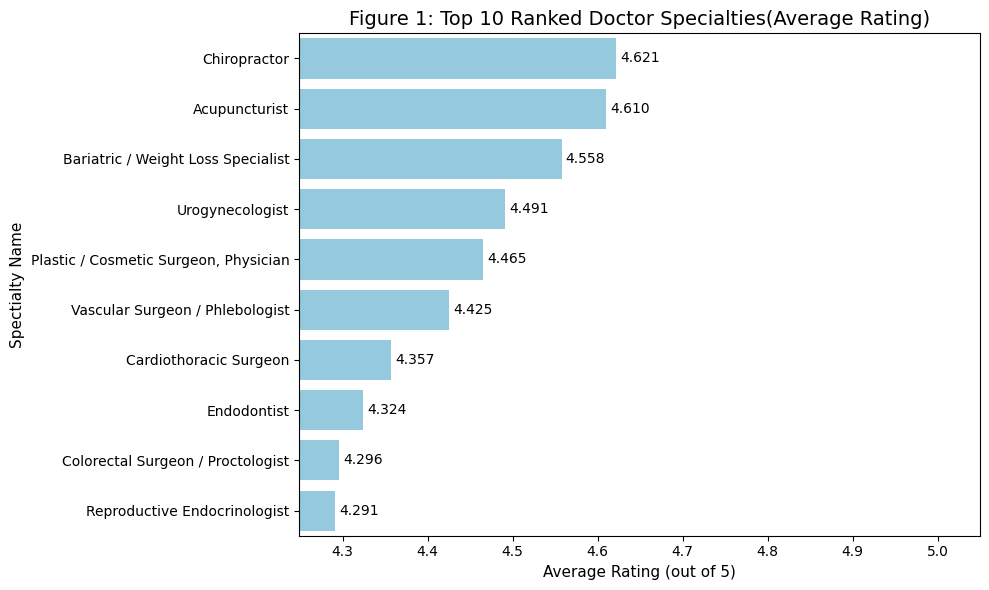

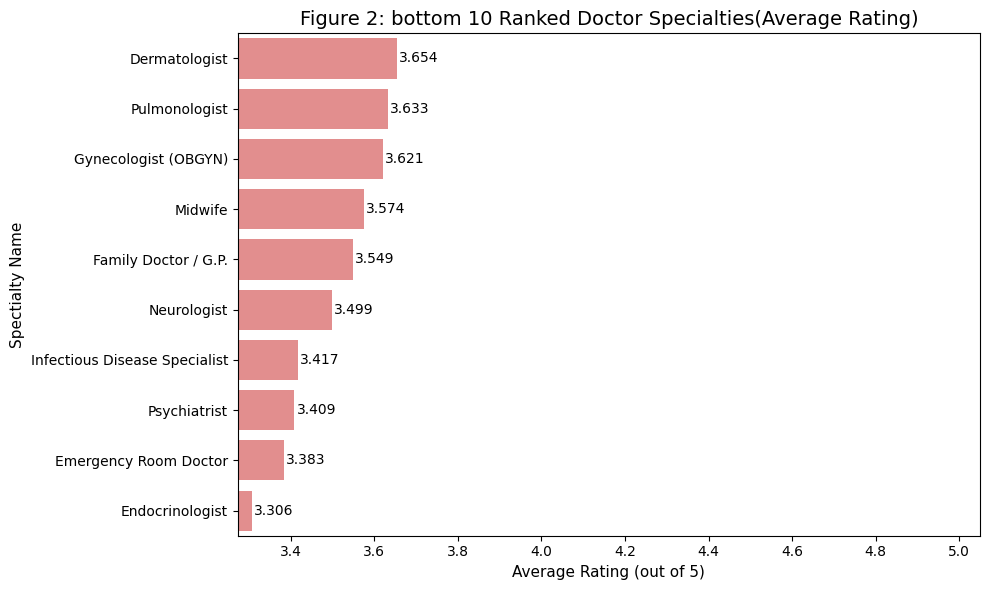

In [20]:
# Model building for Insight 1: the differences in doctor ratings across different specialties
# specialty_result_df is the dataframe already containing rows order by final_average_rating DESC

# Top 10 Bar Chart
# 1. Prepare Top 10 df
top_10_df = specialty_result_df.head(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
top_10_df = top_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Top 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = top_10_df,
    color = 'skyblue'
)
plt.title('Figure 1: Top 10 Ranked Doctor Specialties(Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(top_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(top_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()



# Bottom 10 Bar Chart
# 1. Prepare bottom 10 df
bottom_10_df = specialty_result_df.tail(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
bottom_10_df = bottom_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Bottom 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = bottom_10_df,
    color = 'lightcoral'
)
plt.title('Figure 2: bottom 10 Ranked Doctor Specialties(Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(bottom_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(bottom_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()





## Discussion and Results

## Conclusion

## References

1. Barber, David. Bayesian Reasoning and Machine Learning. Cambridge University Press, 2012.
2. Aste, Tomaso, Paola Cerchiello, and Roberta Scaramozzino. "Information-Theoretic Causality Detection between Financial and Sentiment Data."Entropy, vol. 24, no. 6, 2022, pp. 1–18. DOI:10.3390/e24060774.
3. Metz, Cade. "Microsoft Puts OpenAI’s Sam Altman in Charge of New Advanced AI Research Team."
The New York Times, 20 Nov. 2023, www.nytimes.com/2023/11/20/technology/openai-microsoft-altman.html

## Appendix